#Getting the Data

In [69]:
import datetime as datetime
import numpy
import plotly.plotly as py
from plotly.graph_objs import *
import matplotlib.pyplot as plt
import matplotlib
import plotly
plotly.tools.set_credentials_file(username='pujaarajan', api_key='7m16vvaw4j')
from collections import defaultdict
import time
import plotly.tools as tls

In [47]:
import json
sqlc = HiveContext(sc)
user_highlights = sc.textFile("s3://ds-fulla/mongo/20150507/monolith/highlights/userhighlights/").map(json.loads)
highlight_views = user_highlights.filter(lambda x: x!= None)\
    .filter(lambda x: 'c' in x.keys())\
    .filter(lambda x: x['c'] != None)\
    .filter(lambda x: len(x['c']) > 0)\
    .filter(lambda x: 'v' in x.keys())\
    .filter(lambda x: x['v'] != None)\
    .filter(lambda x: x['v'] >= 0)\
    .filter(lambda x: no_none(x))

In [48]:
def no_none(x):
    for y in x['c']:
        if y['d']!=None:
            if type(y['d']) == int and int(y['d'])<=0:
                yield False
            elif type(y['d']) == int and len(str(int(y['d'])))<5:
                yield False
            else:
                yield True
        else:
            yield False

In [49]:
def get_sec(s):
    L = s.split(':')
    if len(L) == 1:
        return L[0]
    elif len(L) == 2:
        datee = datetime.datetime.strptime(s, "%M:%S")
        return datee.minute * 60 + datee.second
    elif len(L) == 3:
        datee = datetime.datetime.strptime(s, "%H:%M:%S")
        return datee.hour * 3600 + datee.minute * 60 + datee.second

In [50]:
def duration(x):
    s = 0
    clip_dictionary = x['c']
    for clip in clip_dictionary:
        if type(clip['d']) == int and (len(str(clip['d'])) == 5 or len(str(clip['d'])) == 6 or len(str(clip['d'])) == 7 or len(str(clip['d'])) == 8 or len(str(clip['d'])) == 9):
            s = (clip['d']/10000000) * 60
        elif type(clip['d']) == int and len(str(clip['d'])) == 10:
            s = (clip['d']/10000000)
        elif type(clip['d']) == int and len(str(clip['d'])) == 11:
            s = s + ((int(clip['d'])/10000000)/60)
        elif type(clip['d']) == unicode and len(clip['d']) == 8:
            s = s + get_sec(clip['d'])
        elif type(clip['d']) == unicode and len(clip['d']) == 16:
            s = s + get_sec(clip['d'][0:8])
        else:
            continue
    return s

In [51]:
def reject_xoutliers(data):
    x_data = [x[0] for x in data]
    third_quartile = numpy.percentile(x_data, 75)
    first_quartile = numpy.percentile(x_data, 25)
    outlier = (third_quartile - first_quartile)*3
    lower_limit = first_quartile - outlier
    upper_limit = third_quartile + outlier
    new_data = []
    x_count = 0
    for x in x_data:
        if x < 0:
            x_count = x_count + 1
        elif x_data[x_count] < upper_limit and x_data[x_count] > lower_limit:
            new_data.append(data[x_count])
            x_count = x_count + 1
        else:
            x_count = x_count + 1
    return new_data

def reject_youtliers(data):
    y_data = [y[1] for y in data]
    third_quartile = numpy.percentile(y_data, 75)
    first_quartile = numpy.percentile(y_data, 25)
    outlier = (third_quartile - first_quartile)*3
    lower_limit = first_quartile - outlier
    upper_limit = third_quartile + outlier
    new_data = []
    y_count = 0
    for y in y_data:
        if y_data[y_count] < upper_limit and y_data[y_count] > lower_limit:
            new_data.append(data[y_count])
            y_count = y_count + 1
        else:
            y_count = y_count + 1
    return new_data

In [52]:
lengths = highlight_views.map(lambda x: duration(x)).filter(lambda x: x >= 0)
lengths.stats()

(count: 6921001, mean: 953.25483597, stdev: 689.972487835, max: 5946.0, min: 0.0)

In [54]:
length_view = highlight_views.map(lambda x: (duration(x), x['v']) ).filter(lambda x: x[0] >= 0)

In [57]:
list_length_view = length_view.collect()

In [60]:
#(duration, number of views)
length_views = length_view.reduceByKey(lambda a,b: a+b).collect()

#(duration, number of clips with that duration)
length_frequency = highlight_views.map(lambda x: (duration(x), 1)).filter(lambda x: x[0] >= 0).reduceByKey(lambda a,b: a+b).collect()


In [59]:
dict_length_freq = dict(length_frequency)

#Visualizing the data

Histogram: Duration vs Frequency

In [80]:
data = Data([Histogram(x=lengths.collect())])

layout = dict(
   title='Public Highlight Analysis',
   yaxis=YAxis(
       title = 'Frequency of Durations'),
   xaxis1=XAxis(
       title = "Duration of Highlight in Seconds")
   )
fig = Figure(data=data, layout=layout)
py.iplot(fig)

/usr/local/lib/python2.7/site-packages/plotly/plotly/plotly.py:174: UserWarning:

Woah there! Look at all those points! Due to browser limitations, Plotly has a hard time graphing more than 500k data points for line charts, or 40k points for other types of charts. Here are some suggestions:
(1) Trying using the image API to return an image instead of a graph URL
(2) Use matplotlib
(3) See if you can create your visualization with fewer data points

If the visualization you're using aggregates points (e.g., box plot, histogram, etc.) you can disregard this warning.



Bar Chart: Highlight Length vs Highlight Views

In [79]:
data = Data([
    Bar(
        x=[x[0] for x in length_views],
        y=[y[1] for y in length_views]
    )
])
layout = dict(
   title='Public Highlight Analysis',
   yaxis=YAxis(
       title = 'Total Views at a Duration'),
   xaxis1=XAxis(
       title = "Duration of Highlight in Seconds"),
   )
fig = Figure(data=data, layout=layout)
py.iplot(fig)

Bar Chart: Duration of Highlight in Seconds vs Average number of views at this length

In [15]:
[x[0] for x in list_length_view][0:5]

[1140, 840, 1140, 1380, 1260]

In [16]:
[y[1] for y in list_length_view][0:5]

[1, 10, 1, 2, 1]

In [62]:
%matplotlib inline
import math
from matplotlib.colors import LogNorm



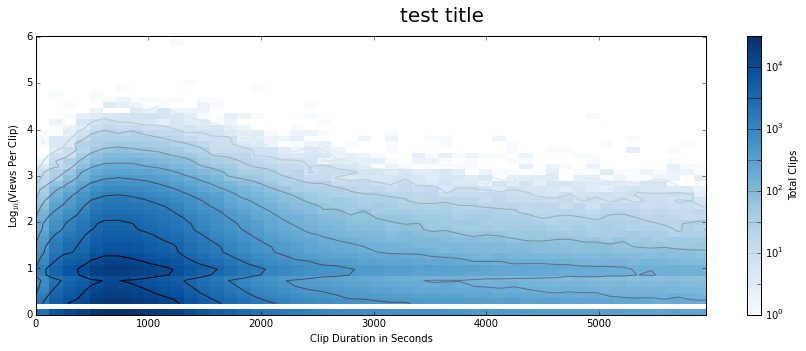

In [103]:
def frange(x, y, jump):
  while x < y:
    yield x
    x += jump
    
def plot_mpl_fig():
    xy = [(x[0], math.log10(x[1])) for x in list_length_view if x[0] > 0 and x[1] > 0]
    fig = plt.figure(figsize=(15, 5), dpi=100, facecolor='w', edgecolor='w')
    counts, xbins, ybins, image = \
        plt.hist2d([x[0] for x in xy], [x[1] for x in xy], 
               bins=(50, 50),  # range=numpy.array([(0, 4), (0, 6)]),
               norm=LogNorm(), cmap='Blues')
    cb1 = plt.colorbar()
    CS = plt.contour(counts.transpose(), levels=[10**x for x in frange(0,5,0.5)],
                     extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],
                     linewidths=1, norm=LogNorm(), cmap='bone_r')
    cb2 = plt.colorbar(CS,cax=cb1.ax, extend='both')
    plt.xlabel('Highlight Duration in Seconds')
    plt.ylabel(r'Log$_{10}$(Highlight Views)')
    cb1.set_label(r'Total Highlights')
    fig.suptitle('Highlight Duration vs Highlight Views')


plot_mpl_fig()
mpl_fig1 = plt.gcf()